In [111]:
import pandas as pd
import torch
import torch_geometric as pyg

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

from sentence_transformers import SentenceTransformer

from torch_geometric.transforms import RandomLinkSplit, RandomNodeSplit
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
import matplotlib.pyplot as plt

from torch_geometric import seed_everything

seed_everything(42)  # so that the results are reproducible


In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(device)

mps


In [3]:
device = "cpu"

## Load data

In [132]:
df_books = pd.read_csv('../data/books.csv')[['book_id', 'title', 'authors']]    # TODO: think about using also the columns

df_ratings = pd.read_csv('../data/ratings.csv').sample(1000000)  # FIXME: remove the sampling on the final run

print(df_books.columns)

Index(['book_id', 'title', 'authors'], dtype='object')


<Axes: >

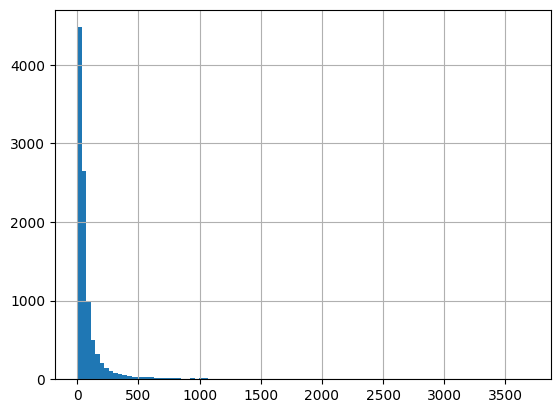

In [133]:
df_ratings.groupby('book_id').size().hist(bins=100)

In [134]:
# Create features
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)

In [135]:
# Books features
df_books["text_to_embed"] = "Title: " + df_books["title"] + " Authors: " + df_books["authors"]
with torch.no_grad():
    titles_emb = model.encode(df_books['text_to_embed'].values, device=device, show_progress_bar=True, batch_size=32)
    
del model
torch.cuda.empty_cache()    

books_features = torch.tensor(titles_emb)
print("Books features shape:", books_features.shape)

# Users features: as we don't have any information we will use random features
# users_features = torch.rand(df_ratings['user_id'].nunique(), 768, device=device)
# print("Users features shape:", users_features.shape)

Batches: 100%|██████████| 313/313 [00:19<00:00, 15.78it/s]

Books features shape: torch.Size([10000, 384])


In [136]:
# embedding users

# # Create a bipartite graph
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(df_ratings['user_id'].unique(), bipartite=0)  # Users
B.add_nodes_from(df_ratings['book_id'].unique(), bipartite=1)  # Books

# Add edges between users and books
for _, row in tqdm(df_ratings.iterrows(), total=df_ratings.shape[0], desc="Adding edges"):
    B.add_edge(row['user_id'], row['book_id'], weight=row['rating'])

# Compute metrics
centrality = nx.degree_centrality(B)
print('degree centrality computed')
pagerank = nx.pagerank(B, weight='weight')
print('pagerank computed')
average_rating = df_ratings.groupby('user_id')['rating'].mean()
print('all metrics computed')

# # Prepare feature vectors for users
features = pd.DataFrame(index=df_ratings['user_id'].unique())
features['degree'] = [centrality[node] for node in features.index]
features['pagerank'] = [pagerank[node] for node in features.index]
features['average_rating'] = [average_rating.get(node, 0) for node in features.index]  # Add average ratings

# # Normalize features
scaler = MinMaxScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)

# # Display the normalized features
users_features = features_scaled.to_numpy()

features_scaled.head() 

Adding edges: 100%|██████████| 1000000/1000000 [00:41<00:00, 23943.01it/s]


degree centrality computed
pagerank computed
all metrics computed


,degree,pagerank,average_rating
38567,0.004318,0.003838,0.897059
38072,0.005128,0.004453,0.875000
24383,0.008367,0.006467,0.742188
15705,0.006748,0.005679,0.826923
24319,0.006748,0.004500,0.625000


In [137]:
# Merge the two dataframes keeping user_id, book_id, rating, title, authors
df_ratings = pd.merge(df_ratings, df_books, on='book_id')
df_ratings.head()

,user_id,book_id,rating,title,authors,text_to_embed
0,38567,72,5,The Shining (The Shining #1),Stephen King,Title: The Shining (The Shining #1) Authors: S...
1,38072,6,4,The Fault in Our Stars,John Green,Title: The Fault in Our Stars Authors: John Green
2,24383,12,4,"Divergent (Divergent, #1)",Veronica Roth,"Title: Divergent (Divergent, #1) Authors: Vero..."
3,15705,3505,5,Giovanni's Room,James Baldwin,Title: Giovanni's Room Authors: James Baldwin
4,24319,8449,2,Wench,Dolen Perkins-Valdez,Title: Wench Authors: Dolen Perkins-Valdez


In [138]:
# Create a mapping from the user_id to a unique consecutive value in the range [0, num_users]:
unique_user_id = df_ratings['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id, 
    'mapped_user_id': pd.RangeIndex(len(unique_user_id))
    })
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()

# Create a mapping from the book_id to a unique consecutive value in the range [0, num_books]:
unique_book_id = df_ratings['book_id'].unique()
unique_book_id = pd.DataFrame(data={
    'book_id': unique_book_id,
    'mapped_book_id': pd.RangeIndex(len(unique_book_id))
    })
print("Mapping of book IDs to consecutive values:")
print("===========================================")
print(unique_book_id.head())
print()

Mapping of user IDs to consecutive values:
   user_id  mapped_user_id
0    38567               0
1    38072               1
2    24383               2
3    15705               3
4    24319               4

Mapping of book IDs to consecutive values:
   book_id  mapped_book_id
0       72               0
1        6               1
2       12               2
3     3505               3
4     8449               4



In [142]:
df_ratings = df_ratings.merge(unique_user_id, on='user_id')
df_ratings = df_ratings.merge(unique_book_id, on='book_id')

# With this, we are ready to create the edge_index representation in COO format
# following the PyTorch Geometric semantics:
edge_index = torch.stack([
    torch.tensor(df_ratings['mapped_user_id'].values), 
    torch.tensor(df_ratings['mapped_book_id'].values)]
    , dim=0)

print(edge_index[:, :10])

KeyError: 'mapped_user_id'

In [ ]:
print(edge_index[:, :10])

In [ ]:

# Create the heterogeneous graph data object:
data = HeteroData()

# Add the user nodes:
data['user'].x = torch.tensor(users_features,).float()  # (num_users, num_users_features)

# Add the book nodes:
data['book'].x = torch.tensor(titles_emb,).float()  # (num_books, num_books_features)

# Add the rating edges:
data['user', 'rates', 'book'].edge_index = edge_index  # (2, num_ratings)

# Add the rating labels:
rating = torch.from_numpy(df_ratings['rating'].values).float()
data['user', 'rates', 'book'].edge_label = rating  # [num_ratings]

# We also need to make sure to add the reverse edges from books to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

# With the above transformation we also got reversed labels for the edges.
# We remove them
del data['book', 'rev_rates', 'user'].edge_label

print(data['user'].num_nodes,len(unique_user_id))
assert data['user'].num_nodes == len(unique_user_id)
assert data['user', 'rates', 'book'].num_edges == len(df_ratings)

data

53423 53423


HeteroData(
  user={ x=[53423, 3] },
  book={ x=[10000, 384] },
  (user, rates, book)={
    edge_index=[2, 1000000],
    edge_label=[1000000],
  },
  (book, rev_rates, user)={ edge_index=[2, 1000000] }
)

## Splitting data

In [143]:
## designed for transductive learning
tfs = RandomLinkSplit(is_undirected=True, 
                      num_val=0.1,
                      num_test=0.1,
                      neg_sampling_ratio=0.0,
                      add_negative_train_samples=False,
                      edge_types=[('user', 'rates', 'book')],
                      rev_edge_types=[('book', 'rev_rates', 'user')],
                      )

train_data, val_data, test_data = tfs(data)

In [144]:
data

HeteroData(
  user={ x=[53423, 3] },
  book={ x=[10000, 384] },
  (user, rates, book)={
    edge_index=[2, 1000000],
    edge_label=[1000000],
  },
  (book, rev_rates, user)={ edge_index=[2, 1000000] }
)

In [145]:
# training has 80% of the edges (plus their label) and the reverse edges
# validation has 80% of the edges and the reverse edges, plus 10% of other edges with their label
# test has 90% of the edges and the reverse edges, plus 10% of other edges with their label

# only tthe first one can be used for training because we have the label of the edges used to compute the embeddings. So with those we can compute the embedding and udpate how these embeddings get computed (weights in the GNN). 
# For the validation and test we have some edges which we use to compute the embeddings (the same ones as before for the validation), but we'll use other edges to do the validation. 
train_data, val_data, test_data

(HeteroData(
   user={ x=[53423, 3] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 800000],
     edge_label=[800000],
     edge_label_index=[2, 800000],
   },
   (book, rev_rates, user)={ edge_index=[2, 800000] }
 ),
 HeteroData(
   user={ x=[53423, 3] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 800000],
     edge_label=[100000],
     edge_label_index=[2, 100000],
   },
   (book, rev_rates, user)={ edge_index=[2, 800000] }
 ),
 HeteroData(
   user={ x=[53423, 3] },
   book={ x=[10000, 384] },
   (user, rates, book)={
     edge_index=[2, 900000],
     edge_label=[100000],
     edge_label_index=[2, 100000],
   },
   (book, rev_rates, user)={ edge_index=[2, 900000] }
 ))

In [146]:
# saving splitted data so that the same dataset can be used for matrix factorization in order to have a fair comparison

# train set
train_labels = train_data['user', 'rates', 'book'].edge_label
train_label_index =  train_data['user', 'rates', 'book'].edge_label_index

concat = torch.cat([train_label_index, train_labels.unsqueeze(0)], dim=0)
train_set = pd.DataFrame(concat.T.numpy(), columns=['user', 'book', 'rating'])
train_set.to_csv('../data/splitted_data/train_set.csv', index=False)

# test set
test_labels = test_data['user', 'rates', 'book'].edge_label
test_label_index =  test_data['user', 'rates', 'book'].edge_label_index

concat = torch.cat([test_label_index, test_labels.unsqueeze(0)], dim=0)
test_set = pd.DataFrame(concat.T.numpy(), columns=['user', 'book', 'rating'])
test_set.to_csv('../data/splitted_data/test_set.csv', index=False)

## Creating the model

In [147]:
from torch_geometric.nn import SAGEConv, to_hetero

class GNNEncoder(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), hidden_channels)
        self.conv3 = SAGEConv((-1, -1), hidden_channels)
        self.conv4 = SAGEConv((-1, -1), out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = self.conv4(x, edge_index)
        return x


class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(2 * hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, 1)

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['book'][col]], dim=-1)

        z = self.lin1(z).relu()
        z = self.lin2(z).relu()
        z = self.lin3(z)
        return z.view(-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.encoder = GNNEncoder(hidden_channels, hidden_channels)
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)


model = Model(hidden_channels=100).to(device)
print(model)

Model(
  (encoder): GraphModule(
    (conv1): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 100, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 100, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 100, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 100, aggr=mean)
    )
    (conv3): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 100, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 100, aggr=mean)
    )
    (conv4): ModuleDict(
      (user__rates__book): SAGEConv((-1, -1), 100, aggr=mean)
      (book__rev_rates__user): SAGEConv((-1, -1), 100, aggr=mean)
    )
  )
  (decoder): EdgeDecoder(
    (lin1): Linear(in_features=200, out_features=100, bias=True)
    (lin2): Linear(in_features=100, out_features=100, bias=True)
    (lin3): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [148]:
from torch_geometric.loader import HGTLoader

train_loader = HGTLoader(
    train_data,
    num_samples=[1024] * 4,  
    shuffle=True,
    batch_size=128,
    input_nodes=("user", None),  # setting to None means that we will use all nodes
)

val_loader = HGTLoader(
    val_data,
    num_samples=[1024] * 4,
    shuffle=False,
    batch_size=128,
    input_nodes=("user", None),
)

# NOTE: also the reverse edges are sampled

In [149]:
for n, p in enumerate(train_loader):
    print(p)
    print(p['user'].input_id)
    for index in p['user', 'rates', 'book'].edge_label_index[0]:
        if index not in p['user'].input_id:
            print(index) # shows that edge label index aren't in the input
            # The sample for the users and (user, rates, book) is independent. that's why we need to pass all the nodes embeddings to the model
    if n == 0:
        break

HeteroData(
  user={
    x=[3200, 3],
    n_id=[3200],
    input_id=[128],
    batch_size=128,
  },
  book={
    x=[3437, 384],
    n_id=[3437],
  },
  (user, rates, book)={
    edge_index=[2, 14228],
    edge_label=[14228],
    edge_label_index=[2, 14228],
    e_id=[14228],
  },
  (book, rev_rates, user)={
    edge_index=[2, 42604],
    e_id=[42604],
  }
)
tensor([49759,  9148, 14141, 20988, 44194, 47593,  5138, 15943, 48703, 18913,
        29770, 46494, 19552, 49707, 37296, 16357, 12273,  4629, 22943, 41613,
        29028,  8903, 11176, 39942, 27959, 16471, 11864, 17743, 37356, 37461,
        33967, 19419, 13742, 45409, 41229, 43508, 20975, 21411, 35821, 35095,
         8495, 19968, 44848, 47342,  4808, 20521, 16505, 28765, 41760, 31969,
        14768, 32319, 24873, 27791, 49280, 20272, 27068, 36421, 27395, 13420,
        26342, 17851,  4697,  8663, 10295, 23454, 51834, 40772, 23154, 12046,
        25724, 41855,   241, 45683, 11095, 38757, 40355, 37634,  1903, 42282,
         4847, 3

In [150]:
data.x_dict

{'user': tensor([[4.3185e-03, 3.8381e-03, 8.9706e-01],
         [5.1282e-03, 4.4527e-03, 8.7500e-01],
         [8.3671e-03, 6.4668e-03, 7.4219e-01],
         ...,
         [0.0000e+00, 9.8732e-05, 1.0000e+00],
         [0.0000e+00, 1.0878e-04, 5.0000e-01],
         [0.0000e+00, 1.2712e-04, 5.0000e-01]]),
 'book': tensor([[ 0.0317, -0.0143, -0.0042,  ..., -0.0083, -0.0774,  0.0136],
         [-0.0539,  0.0106,  0.0059,  ...,  0.0068, -0.0008,  0.0677],
         [ 0.0088,  0.0140,  0.0650,  ..., -0.0836,  0.0070,  0.0468],
         ...,
         [-0.0520,  0.0453,  0.0045,  ..., -0.0343, -0.0043, -0.0555],
         [ 0.0411, -0.0194,  0.0850,  ..., -0.0029,  0.0665,  0.0228],
         [-0.0981,  0.0178,  0.0294,  ..., -0.0602,  0.0098,  0.0154]])}

In [151]:
# Training Loop
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        # print(p['user', 'rates', 'book'].edge_label_index.max())
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(data.x_dict, batch.edge_index_dict, batch['user', 'rates', 'book'].edge_label_index)
        loss = criterion(pred, batch['user', 'rates', 'book'].edge_label.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / (len(data_loader.dataset) / 128)

# Testing Loop
def test(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            pred = model(data.x_dict, batch.edge_index_dict, batch['user', 'rates', 'book'].edge_label_index)
            loss = criterion(pred, batch['user', 'rates', 'book'].edge_label.float())
            total_loss += loss.item()
    return total_loss / (len(data_loader.dataset) / 128)

# Main training and testing routines
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss = test(model, val_loader, criterion)
    
    # val_loss = test(model, val_data, criterion)
    print(f'Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    val_losses.append(val_loss)
    train_losses.append(train_loss)

# Optionally, after training, you can evaluate your model on the test dataset
# test_loss = test(model, test_data, criterion)
# print(f'Test Loss: {test_loss:.4f}')


100%|██████████| 418/418 [02:53<00:00,  2.41it/s]


Epoch: 1, Training Loss: 1.7775, Validation Loss: 0.7469


100%|██████████| 418/418 [02:47<00:00,  2.50it/s]


Epoch: 2, Training Loss: 0.6922, Validation Loss: 0.7445


100%|██████████| 418/418 [02:53<00:00,  2.41it/s]


Epoch: 3, Training Loss: 0.6807, Validation Loss: 0.7323


100%|██████████| 418/418 [02:49<00:00,  2.47it/s]


Epoch: 4, Training Loss: 0.6844, Validation Loss: 0.7343


100%|██████████| 418/418 [02:50<00:00,  2.45it/s]


Epoch: 5, Training Loss: 0.6672, Validation Loss: 0.7246


100%|██████████| 418/418 [02:55<00:00,  2.38it/s]


Epoch: 6, Training Loss: 0.6641, Validation Loss: 0.7211


100%|██████████| 418/418 [02:57<00:00,  2.35it/s]


Epoch: 7, Training Loss: 0.6600, Validation Loss: 0.7183


100%|██████████| 418/418 [02:56<00:00,  2.37it/s]


Epoch: 8, Training Loss: 0.6593, Validation Loss: 0.7172


100%|██████████| 418/418 [02:59<00:00,  2.32it/s]


Epoch: 9, Training Loss: 0.6509, Validation Loss: 0.7160


100%|██████████| 418/418 [03:04<00:00,  2.27it/s]


Epoch: 10, Training Loss: 0.6500, Validation Loss: 0.7249


In [152]:
# Save model 
torch.save(model.state_dict(), "model.pt")

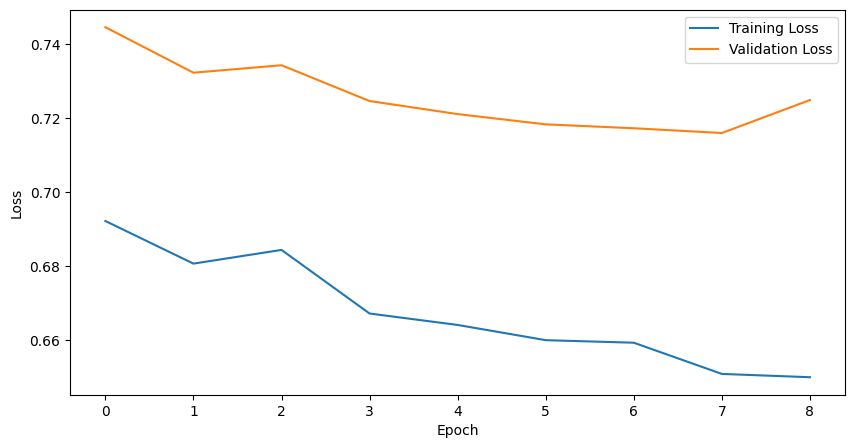

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Training Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Save model 
torch.save(model.state_dict(), "model.pt")

## Validation & metrics

In [ ]:
model = Model(hidden_channels=100).to(device)
model.load_state_dict(torch.load("model.pt"))

In [155]:
pred_review = model(test_data.x_dict, test_data.edge_index_dict, test_data['user', 'rates', 'book'].edge_label_index)

<Axes: >

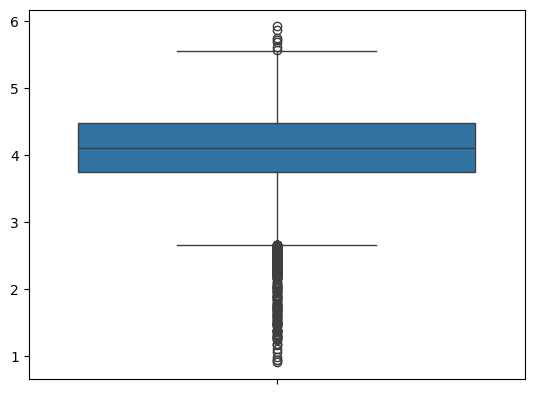

In [156]:
import seaborn as sns
sns.boxplot(pred_review.cpu().detach().numpy())

In [157]:
test_data['user', 'rates', 'book'].edge_label_index

tensor([[25308,  5131, 36528,  ..., 35229, 13655, 48085],
        [  105,   249,  3940,  ...,  1897,  2431,  4900]])

In [158]:
test_data['user', 'rates', 'book'].edge_label

tensor([5., 2., 5.,  ..., 4., 5., 5.])

In [159]:
# Convert tensors to numpy arrays
user_ids_np = test_data['user', 'rates', 'book'].edge_label_index[0].numpy()
book_ids_np = test_data['user', 'rates', 'book'].edge_label_index[1].numpy()
ratings_np = test_data['user', 'rates', 'book'].edge_label.numpy()
ratings_pred_np = pred_review.detach().numpy()

# Create a dictionary with the data
data = {
    'user_id': user_ids_np,
    'book_id': book_ids_np,
    'rating': ratings_np, 
    'predicted_rating': ratings_pred_np
}

# Create a pandas DataFrame
df_ratings = pd.DataFrame(data)

In [160]:
import sys
sys.path.append('../src')
from evaluation_metrics import *

k = 10
top_k_recommendations = get_top_k_recommendations(df_ratings, k)
actual_items = get_actual_items(df_ratings) # ground truth

# Evaluate the recommendations
mean_precision, mean_recall, mean_f1 = evaluate_recommendations(top_k_recommendations, actual_items, k)
print(f"Mean Precision@{k}: {mean_precision}")
print(f"Mean Recall@{k}: {mean_recall}")
print(f"Mean F1 Score@{k}: {mean_f1}")

Mean Precision@10: 0.8223979042070639
Mean Recall@10: 0.9999917535085648
Mean F1 Score@10: 0.8801730944740621


Matrix factorization:

Mean Precision@10: 0.7722234424908242
Mean Recall@10: 0.5475533441372822
Mean F1 Score@10: 0.6128487333956821

In [ ]:
# todo
# visualization on how the data looks like


# report 
# objective and motivation 
# analysis of the data
# method: improving over matrix factorization baseline
# results
# future study: even an idea about how to use diversity